# Traffic Data Analysis
<span style="color:red">This notebook analyzes on traffic congestion prediction, identifying peak hours, Junction Comparison & Analysis and evaluate the performance of predictive models to forecast hourly traffic volumes at different road junctions.</span>

## Import necessary library

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor


## Loading DataSet and Understanding the Data

In [99]:
df=pd.read_csv("Dataset_Uber Traffic.csv")

In [100]:
#Taking overview of the data
df.head(10)

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041
5,01/11/15 5:00,1,6,20151101051
6,01/11/15 6:00,1,9,20151101061
7,01/11/15 7:00,1,8,20151101071
8,01/11/15 8:00,1,11,20151101081
9,01/11/15 9:00,1,12,20151101091


In [101]:
# descriptive statistics of a DataFrame.
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [102]:
# checking data type of columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Data Cleaning and Preprocessing

<span style="color:red">'''
 Dropping ID Column since it doesn't provide predictive information about the number of vehicles or other features. 
'''</span>

In [103]:
df=df.drop('ID',axis=1)

In [104]:
#To check any null value present or not
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

In [105]:
df.duplicated().value_counts()
# To check data contains duplicated rows or not

False    48120
Name: count, dtype: int64

 <span style="color:red">''' there is no duplicated row in the dataset '''</span>

In [106]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

''' <span style="color:red">Converting timestamp column is in the datetime format for proper time-based operations.'''</span>

## Exploratory Data Analysis

- Plotting Distribution of Vehicles count throughout the time

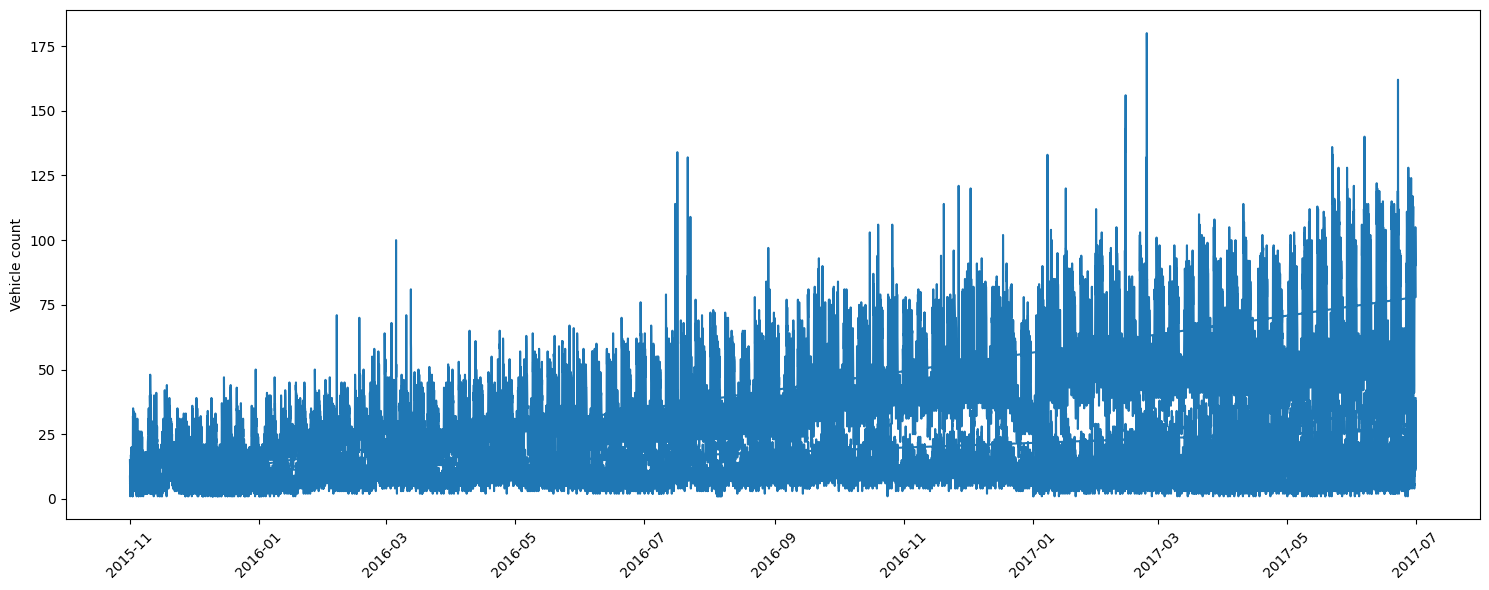

In [107]:
# setting datetime columns as index
df_DateTime_indexed=df.set_index('DateTime')

plt.figure(figsize=(15, 6))
X=pd.Series(df_DateTime_indexed['Vehicles'])
plt.plot(df_DateTime_indexed.index,X)
plt.xticks(rotation=45)
plt.ylabel('Vehicle count')
plt.tight_layout()

- plotting histogram  with kde and boxplot of vehicle


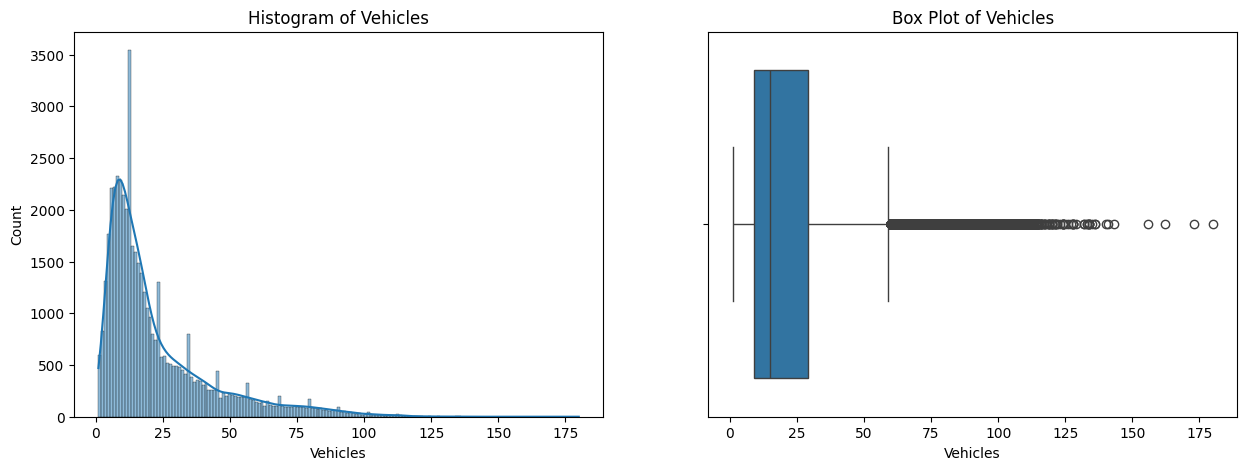

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the histogram on the first axis
sns.histplot(ax=ax1, data=df, x='Vehicles', kde=True)
ax1.set_title('Histogram of Vehicles')

# Plot the box plot on the second axis
sns.boxplot(ax=ax2, x='Vehicles', data=df)
ax2.set_title('Box Plot of Vehicles')

# Display the plot
plt.show()

# Feature Engineering


In [110]:
df['date_year']=df['DateTime'].dt.year            #Extracting year
df['date_month']=df['DateTime'].dt.month          # Extracting month name
df['date_days']=df['DateTime'].dt.day             # Extracting days
df['day_hour']=df['DateTime'].dt.hour             # Extracting hours
df['day_of_week']=df['DateTime'].dt.day_of_week   # Extracting day of week


df['date_is_weekend']=np.where(df['day_of_week'].isin([5,6]),1,0)   # is weekend?
df.sample(5) 

,DateTime,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend
45721,2017-03-23 01:00:00,4,5,2017,3,23,1,3,0
21786,2016-08-26 18:00:00,2,11,2016,8,26,18,4,0
29676,2015-11-21 12:00:00,3,17,2015,11,21,12,5,1
20566,2016-07-06 22:00:00,2,14,2016,7,6,22,2,0
44273,2017-01-21 17:00:00,4,6,2017,1,21,17,5,1


### Setting Congestion level based on vehicle counts at junctions

In [111]:
df['Congestion_level']=np.where(df['Vehicles']<=60,'low',
                                np.where((df['Vehicles']>60 ) & (df['Vehicles']<=120),'medium',
                                'high'))

In [112]:
df.sample(5)

,DateTime,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level
11906,2017-03-11 02:00:00,1,48,2017,3,11,2,5,1,low
26996,2017-03-31 20:00:00,2,31,2017,3,31,20,4,0,low
4307,2016-04-28 11:00:00,1,53,2016,4,28,11,3,0,low
28193,2017-05-20 17:00:00,2,22,2017,5,20,17,5,1,low
20365,2016-06-28 13:00:00,2,18,2016,6,28,13,1,0,low


### Compile traffic data into hourly intervals for each junction.

In [113]:
grouped_df = df.groupby(['Junction', 'day_hour']).agg({'Vehicles': 'sum'}).reset_index()
grouped_df

,Junction,day_hour,Vehicles
0,1,0,27809
1,1,1,23807
2,1,2,20616
3,1,3,17894
4,1,4,15598
...,...,...,...
91,4,19,1602
92,4,20,1636
93,4,21,1525
94,4,22,1586


<Axes: xlabel='day_hour', ylabel='Vehicles'>

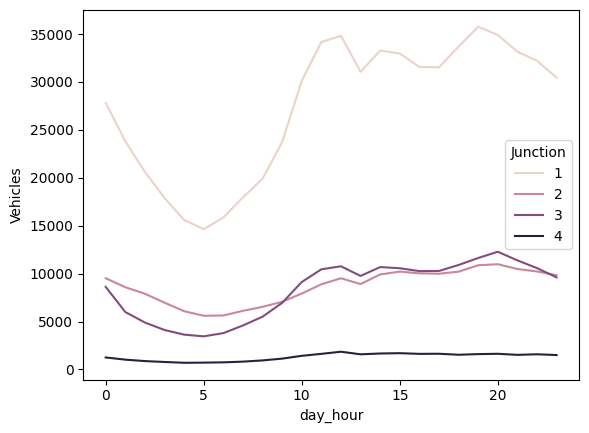

In [114]:
sns.lineplot(x='day_hour',y='Vehicles',data=grouped_df,hue='Junction')

- <span style="color:red">We can see that Junction 1 is very busy area among all junctions, specially from  8:00 AM</span>
- <span style="color:red">While Junction 4 has very less vehicles count</span>
- <span style="color:red">Junction 2 and 3 has low to moderate vehicle count</span>

### Plotting autocorrelation, partial autocorrelation to get an idea about the k significant lag features

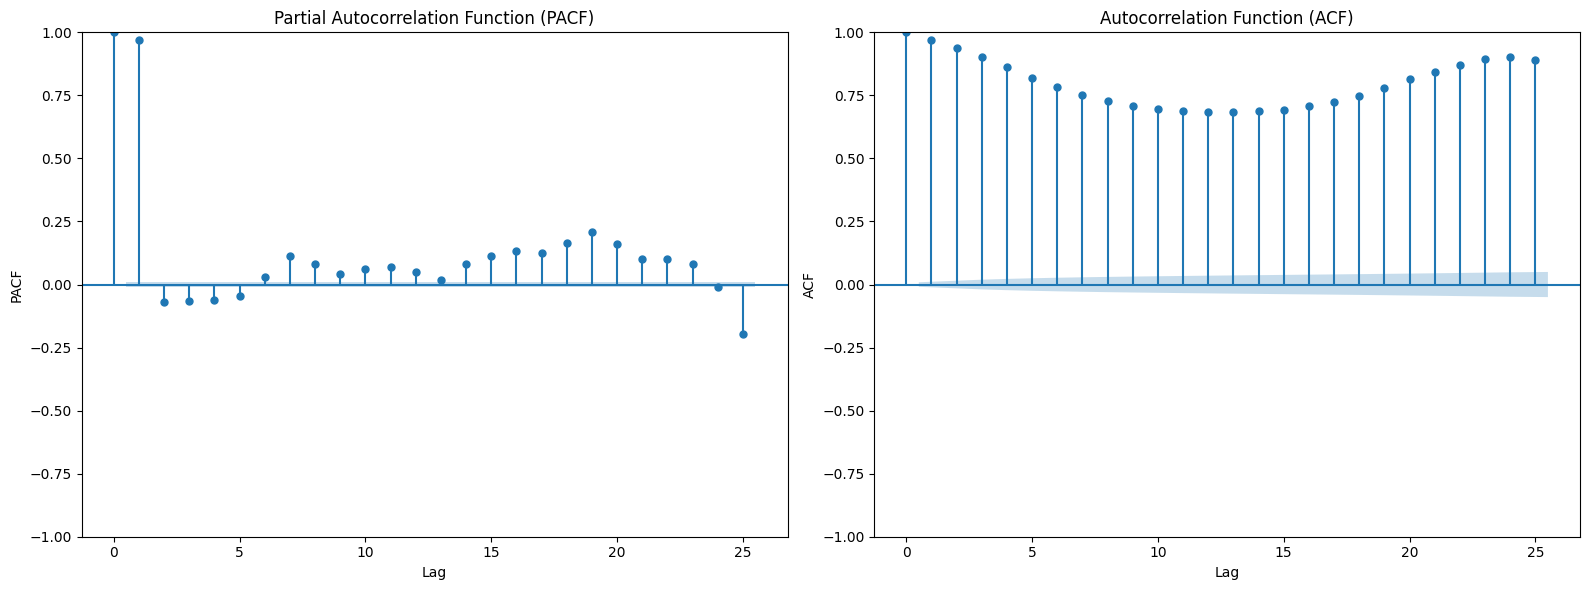

In [115]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot PACF
plot_pacf(df['Vehicles'], lags=25, alpha=0.05, ax=ax1)
ax1.set_title('Partial Autocorrelation Function (PACF)')
ax1.set_xlabel('Lag')
ax1.set_ylabel('PACF')

# Plot ACF
plot_acf(df['Vehicles'], lags=25, alpha=0.05, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('ACF')

plt.tight_layout()
plt.show()


- <span style="color:red">The ACF plot exhibits a decaying pattern with significant spikes across multiple lags, suggesting that an Autoregressive Moving Average (ARMA) or Autoregressive Integrated Moving Average (ARIMA) model might be appropriate if the time series is stationary or needs differencing, respectively.</span>
- <span style="color:red">The PACF plot indicates that lags 1 and 2 are most significant, but we can also consider including additional lags up to where the PACF becomes insignificant, typically around lag 5 or 6 based on the plot.</span>

### creating lag features of Vehicles from previous hours to capture temporal dependencies

In [116]:
# Create hourly lags fro vehicle column
df['Vehicles_lag1'] = df['Vehicles'].shift(1)  # Lag of 1 hour
df['Vehicles_lag2'] = df['Vehicles'].shift(2)  # Lag of 2 hours
df['Vehicles_lag3'] = df['Vehicles'].shift(3)  # Lag of 3 hours
df['Vehicles_lag4'] = df['Vehicles'].shift(4)  # Lag of 4 hours
df['Vehicles_lag5'] = df['Vehicles'].shift(5)  # Lag of 5 hours


In [117]:
df.head(5)

,DateTime,Junction,Vehicles,date_year,date_month,date_days,day_hour,day_of_week,date_is_weekend,Congestion_level,Vehicles_lag1,Vehicles_lag2,Vehicles_lag3,Vehicles_lag4,Vehicles_lag5
0,2015-11-01 00:00:00,1,15,2015,11,1,0,6,1,low,NaN,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,13,2015,11,1,1,6,1,low,15.0,NaN,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,10,2015,11,1,2,6,1,low,13.0,15.0,NaN,NaN,NaN
3,2015-11-01 03:00:00,1,7,2015,11,1,3,6,1,low,10.0,13.0,15.0,NaN,NaN
4,2015-11-01 04:00:00,1,9,2015,11,1,4,6,1,low,7.0,10.0,13.0,15.0,NaN


### Normalize or standardize the data to facilitate comparison across different time periods and junctions.

In [118]:
# Instantiate the scaler
scaler = MinMaxScaler()

# Select the features to normalize
numerical_cols = ['Vehicles', 'date_month', 'date_days', 'day_hour', 'Vehicles_lag1', 'Vehicles_lag2', 'Vehicles_lag3','Vehicles_lag4','Vehicles_lag5']

# Apply the scaler to the selected features
normalized_data = scaler.fit_transform(df[numerical_cols])

# One-hot encode categorical features with get_dummies
encoded_data = pd.get_dummies(df,columns=['Junction', 'day_of_week', 'date_year', 'Congestion_level'], drop_first=True)

# Convert the normalized data back to a DataFrame and retain column names
normalized_df = pd.DataFrame(normalized_data, columns=[f"{col}_normalized" for col in numerical_cols])

# Concatenate the encoded DataFrame with the normalized DataFrame
df_norm = pd.concat([encoded_data, normalized_df], axis=1)

# Display the updated DataFrame with both original and normalized features
boolean_columns = df_norm.select_dtypes(include=['bool']).columns
df_norm[boolean_columns] = df_norm[boolean_columns].astype(int)
df_norm=df_norm.drop(numerical_cols,axis=1)
df_norm.head(5)

,DateTime,date_is_weekend,Junction_2,Junction_3,Junction_4,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,Congestion_level_medium,Vehicles_normalized,date_month_normalized,date_days_normalized,day_hour_normalized,Vehicles_lag1_normalized,Vehicles_lag2_normalized,Vehicles_lag3_normalized,Vehicles_lag4_normalized,Vehicles_lag5_normalized
0,2015-11-01 00:00:00,1,0,0,0,0,0,0,0,0,...,0,0.078212,0.909091,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
1,2015-11-01 01:00:00,1,0,0,0,0,0,0,0,0,...,0,0.067039,0.909091,0.0,0.043478,0.078212,NaN,NaN,NaN,NaN
2,2015-11-01 02:00:00,1,0,0,0,0,0,0,0,0,...,0,0.050279,0.909091,0.0,0.086957,0.067039,0.078212,NaN,NaN,NaN
3,2015-11-01 03:00:00,1,0,0,0,0,0,0,0,0,...,0,0.033520,0.909091,0.0,0.130435,0.050279,0.067039,0.078212,NaN,NaN
4,2015-11-01 04:00:00,1,0,0,0,0,0,0,0,0,...,0,0.044693,0.909091,0.0,0.173913,0.033520,0.050279,0.067039,0.078212,NaN


## correlation analysis of features with the target variable- 'Vehicle' 

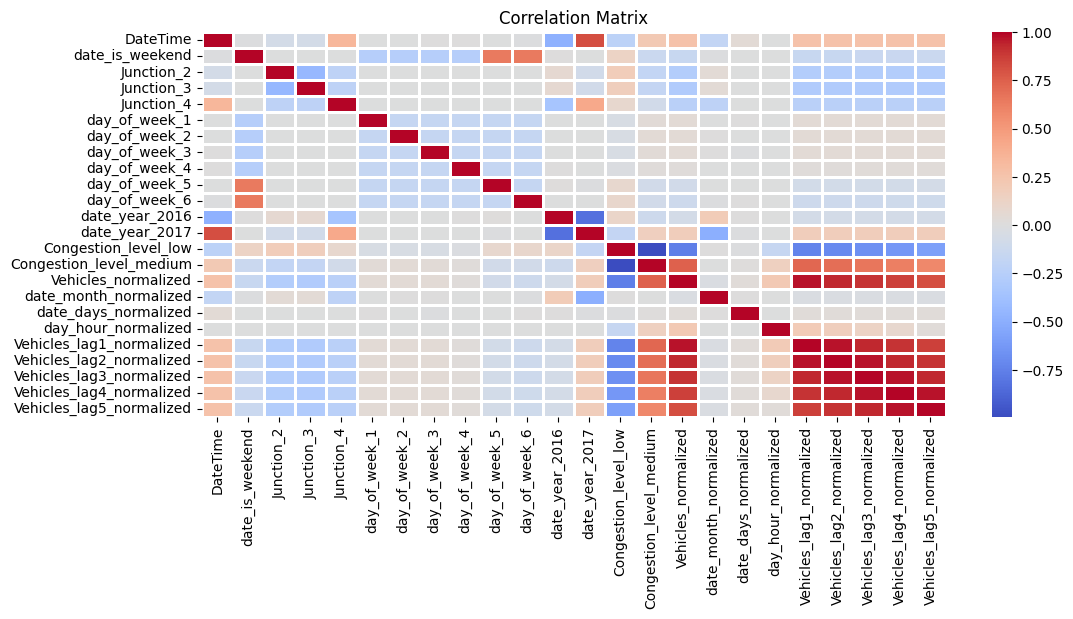

Correlation with the target variable 'Vehicle' 

Vehicles_normalized         1.000000
Vehicles_lag1_normalized    0.969982
Vehicles_lag2_normalized    0.936816
Vehicles_lag3_normalized    0.900645
Vehicles_lag4_normalized    0.861642
Vehicles_lag5_normalized    0.820818
Congestion_level_medium     0.746052
DateTime                    0.266244
day_hour_normalized         0.219938
date_year_2017              0.180481
day_of_week_1               0.049153
day_of_week_3               0.046517
day_of_week_2               0.046454
date_days_normalized        0.027895
day_of_week_4               0.019910
date_month_normalized      -0.022723
date_year_2016             -0.074470
day_of_week_5              -0.082969
day_of_week_6              -0.111422
date_is_weekend            -0.150550
Junction_4                 -0.235915
Junction_2                 -0.271457
Junction_3                 -0.289236
Congestion_level_low       -0.758496
Name: Vehicles_normalized, dtype: float64


In [119]:
correlation_matrix = df_norm.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12,5))

sns.heatmap(correlation_matrix,linewidths=2, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print("Correlation with the target variable 'Vehicle' \n")
target_correlation = correlation_matrix['Vehicles_normalized'].sort_values(ascending=False)
print(target_correlation)

- <span style="color:red">The lag features (Vehicles_lagX_normalized) have strong negative correlations with the target variable 'Vehicle', indicating their significance in time series forecasting.</span>
- <span style="color:red">Although date_month_normalized and date_days_normalized have low correlations, they may still be useful for capturing seasonal or long-term trends in traffic patterns.</span>
- <span style="color:red">Features like day_of_week, day_hour_normalized, and junction features (Junction_2, Junction_3, Junction_4) have relatively weak correlations with the target variable. However, these features are still crucial for performing weekly/hourly traffic analysis and junction comparisons, as they capture the temporal and spatial patterns of traffic.</span>

### Feature Importance measure using Random Forest

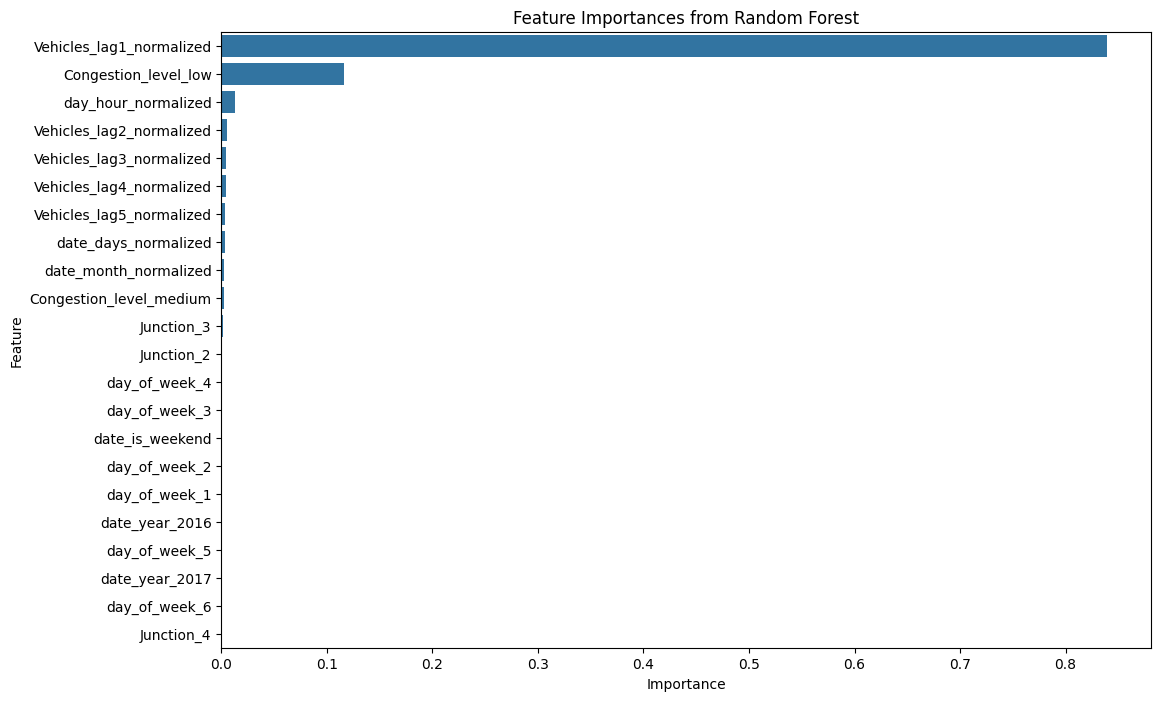

In [120]:
X = df_norm.drop(columns=['Vehicles_normalized','DateTime'])  # Dropping target and datetime columns
y = df_norm['Vehicles_normalized']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()
